<a href="https://colab.research.google.com/github/kam3545/myrepo/blob/master/Down_Case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.1 MB/s eta 0:00:00


In [4]:
import netCDF4
import numpy as np

# Download data to our local directory
!wget -c https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/precipitation_downscaling/scale_rzc.txt
!wget -c https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/precipitation_downscaling/samples-2018-32x32.nc

# Load the samples
with netCDF4.Dataset("samples-2018-32x32.nc", 'r') as ds:
    samples = np.array(ds["samples"][:], copy=False)

# the original data is in an 8-bit format that needs to be scaled
scale = np.loadtxt("scale_rzc.txt").astype(np.float32)
samples = scale[samples]

# convert missing data to zeros
samples[~np.isfinite(samples)] = 0

# Do a log-transformation to reduce dynamic range.
# We threshold data to 0.1 mm/h and set everything below to 0.02 mm/h
# to allow the log-transformation to work.
samples[samples < 0.1] = 0.02 
samples = np.log10(samples)

--2023-05-28 01:59:27--  https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/precipitation_downscaling/scale_rzc.txt
Resolving get.ecmwf.int (get.ecmwf.int)... 136.156.238.204
Connecting to get.ecmwf.int (get.ecmwf.int)|136.156.238.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3283 (3.2K) [text/plain]
Saving to: ‘scale_rzc.txt’

scale_rzc.txt       100%[===================>]   3.21K  --.-KB/s    in 0s      

2023-05-28 01:59:28 (568 MB/s) - ‘scale_rzc.txt’ saved [3283/3283]

--2023-05-28 01:59:28--  https://get.ecmwf.int/repository/mooc-machine-learning-weather-climate/tier_3/precipitation_downscaling/samples-2018-32x32.nc
Resolving get.ecmwf.int (get.ecmwf.int)... 136.156.238.204
Connecting to get.ecmwf.int (get.ecmwf.int)|136.156.238.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16538709 (16M) [application/x-netcdf]
Saving to: ‘samples-2018-32x32.nc’

samples-2018-32x32. 100%[===================

In [5]:
import tensorflow as tf

rf = 8 # resolution factor

# Create low-resolution (LR) array
lr_shape = (
    samples.shape[0], samples.shape[1]//rf,
    samples.shape[2]//rf, samples.shape[3]
)

# 8x8 average pooling
samples_lr = np.zeros(lr_shape, samples.dtype)
for i in range(rf):
    for j in range(rf):
        samples_lr += samples[:,i::rf,j::rf,:]
samples_lr /= rf**2

# set aside 10% of data for testing (not used to train model)
indices = np.arange(samples.shape[0])
rng = np.random.RandomState(seed=1)
rng.shuffle(indices)
N_testing = int(samples.shape[0]*0.1)
samples_test = samples[indices[:N_testing],...]
samples = samples[indices[N_testing:],...]
samples_lr_test = samples_lr[indices[:N_testing],...]
samples_lr = samples_lr[indices[N_testing:],...]

# create TensorFlow Dataset for training
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((samples_lr, samples))
dataset = dataset.shuffle(buffer_size=256).batch(batch_size)

In [6]:
from matplotlib import colors, gridspec, pyplot as plt

def plot_precip(ax, logR):
    """ Plot a single precipitation image.
    """
    if logR.ndim == 3:
        logR = logR[:,:,0] # remove channels dimension
    R = 10**logR
    R[R < 0.1] = np.nan
    ax.imshow(R, norm=colors.LogNorm(0.1,100,clip=True))
    ax.tick_params(left=False, bottom=False,
        labelleft=False, labelbottom=False)

def plot_samples(samples, labels=None):
    """ Plot a grid with many images.
    """
    N_variables = len(samples)
    N_samples = len(samples[0])
    fig = plt.figure(figsize=(N_samples*1.5, N_variables*1.5))
    gs = gridspec.GridSpec(N_variables, N_samples, hspace=0.02, wspace=0.02)

    for (i,variable) in enumerate(samples):
        for (j,sample) in enumerate(variable):
            ax = fig.add_subplot(gs[i,j])
            plot_precip(ax, sample)
            if (j == 0) and (labels is not None):
                ax.set_ylabel(labels[i])

    fig.show()

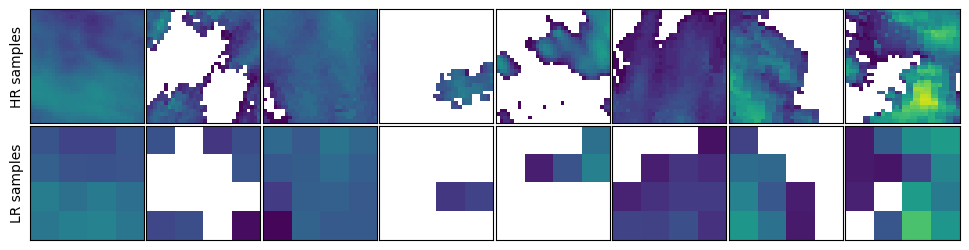

In [7]:
# Show a selection of interesting samples from the test set
indices = [2,5,14,16,17,19,28,37]

# Uncomment to use a random selection (change seed for a different selection):
# rng = np.random.RandomState(seed=4)
# indices = rng.choice(samples_test.shape[0], 8, replace=False)

plot_samples(
    [samples_test[indices,...], samples_lr_test[indices,...]],
    labels=["HR samples", "LR samples"]
)

In [8]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Concatenate, Conv2D, Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, UpSampling2D


def create_generator(
    block_widths=(128,64,32),
    input_shape=(4,4,1),
    noise_shape=(4,4,8)
):
    # inputs (concatenated)
    input_lr = Input(shape=input_shape)
    input_noise = Input(shape=noise_shape)
    x = Concatenate()([input_lr, input_noise])

    x = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same'
    )(x)
    x = LeakyReLU(0.2)(x)
    # upsampling stages
    for width in block_widths:
        x = UpSampling2D(interpolation='bilinear')(x)
        x = Conv2D(
            width, kernel_size=(3,3), padding='same'
        )(x)
        x = LeakyReLU(0.2)(x)

    # final projection to output space
    output = Conv2D(1, kernel_size=(1,1))(x)

    return Model(inputs=[input_lr, input_noise], outputs=output)


def create_discriminator(
    block_widths=(32,64,128),
    input_shape_hr=(32,32,1),
    input_shape_lr=(4,4,1),
    postproc_convs=2,
    output_activation='linear' # 'linear' when using 'from_logits' in loss
):
    # inputs
    input_hr = Input(shape=input_shape_hr)
    input_lr = Input(shape=input_shape_lr)

    # Convolution steps for both HR and LR inputs
    x_hr = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same', activation='relu'
    )(input_hr)
    x_hr = LeakyReLU(0.2)(x_hr)
    x_lr = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same', activation='relu'
    )(input_lr)
    x_lr = LeakyReLU(0.2)(x_lr)
    for width in block_widths:
        x_hr = Conv2D( # downsample HR samples on each loop
            width, kernel_size=(3,3), padding='same', strides=2,
        )(x_hr)
        x_hr = LeakyReLU(0.2)(x_hr)
        x_lr = Conv2D(
            width, kernel_size=(3,3), padding='same'
        )(x_lr)
        x_lr = LeakyReLU(0.2)(x_lr)

    # Concatenate HR and LR branches and do some joint processing
    x = Concatenate()([x_hr, x_lr])
    for _ in range(postproc_convs):
        x = Conv2D(block_widths[-1], kernel_size=(3,3), padding='same')(x)
        x = LeakyReLU(0.2)(x)

    # Pool to get outputs
    x = GlobalAveragePooling2D()(x)
    output = Dense(1, activation=output_activation)(x)

    return Model(inputs=[input_lr, input_hr], outputs=output)


generator = create_generator()
discriminator = create_discriminator()

In [9]:
# Print summaries of the model
generator.summary()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 4, 1)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4, 4, 8)]    0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 4, 4, 9)      0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 4, 4, 128)    10496       ['concatenate[0][0]']        

In [10]:
# Adapted from https://keras.io/examples/generative/conditional_gan/

class DownscalingGAN(Model):
    def __init__(self, discriminator, generator, noise_shape=(4,4,8)):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_shape = noise_shape
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.step_number = tf.Variable(0)

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        (samples_lr, samples_hr) = data

        # Sample noise for the generator.
        batch_size = tf.shape(samples_hr)[0]
        noise = tf.random.normal(
            shape=(batch_size,)+self.noise_shape
        )

        def train_discriminator():
            # Generate fake samples.
            samples_gen = self.generator([samples_lr, noise])

            # Combine them with real images.
            combined_samples_hr = tf.concat([samples_gen, samples_hr], axis=0)
            combined_samples_lr = tf.concat([samples_lr, samples_lr], axis=0)

            # Assemble labels discriminating real from fake images.
            labels = tf.concat(
                [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            )

            # Train the discriminator.
            with tf.GradientTape() as tape:
                predictions = self.discriminator(
                    [combined_samples_lr, combined_samples_hr]
                )
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

            # Monitor loss.
            self.disc_loss_tracker.update_state(d_loss)

        def train_generator():
            # Create labels that say "all real images".
            misleading_labels = tf.zeros((batch_size, 1))

            # Train the generator (note that we should *not* update the weights
            # of the discriminator)!
            with tf.GradientTape() as tape:
                samples_gen = self.generator([samples_lr, noise])
                predictions = self.discriminator([samples_lr, samples_gen])
                g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(
                zip(grads, self.generator.trainable_weights)
            )

            # Monitor loss.
            self.gen_loss_tracker.update_state(g_loss)
        
        # If we trained the generator now, train the discriminator next
        # or vice versa.
        
        tf.cond(
            self.step_number % 2 == 0,
            train_discriminator,
            train_generator
        )        
        self.step_number.assign(self.step_number+1)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

gan = DownscalingGAN(discriminator, generator)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)


In [13]:
gan.fit(dataset, epochs=100)

Epoch 1/100
900/900 [==============================] - 12s 13ms/step - g_loss: 5.6809 - d_loss: 0.2117
Epoch 2/100
900/900 [==============================] - 11s 12ms/step - g_loss: 5.1143 - d_loss: 0.2328
Epoch 3/100
900/900 [==============================] - 11s 12ms/step - g_loss: 5.5670 - d_loss: 0.2302
Epoch 4/100
900/900 [==============================] - 11s 12ms/step - g_loss: 4.8062 - d_loss: 0.3039
Epoch 5/100
900/900 [==============================] - 11s 12ms/step - g_loss: 6.0638 - d_loss: 0.1982
Epoch 6/100
900/900 [==============================] - 11s 12ms/step - g_loss: 6.4550 - d_loss: 0.1785
Epoch 7/100
900/900 [==============================] - 11s 12ms/step - g_loss: 6.0106 - d_loss: 0.2156
Epoch 8/100
900/900 [==============================] - 11s 12ms/step - g_loss: 5.8369 - d_loss: 0.2157
Epoch 9/100
900/900 [==============================] - 10s 11ms/step - g_loss: 5.8260 - d_loss: 0.2354
Epoch 10/100
900/900 [==============================] - 11s 12ms/step - g

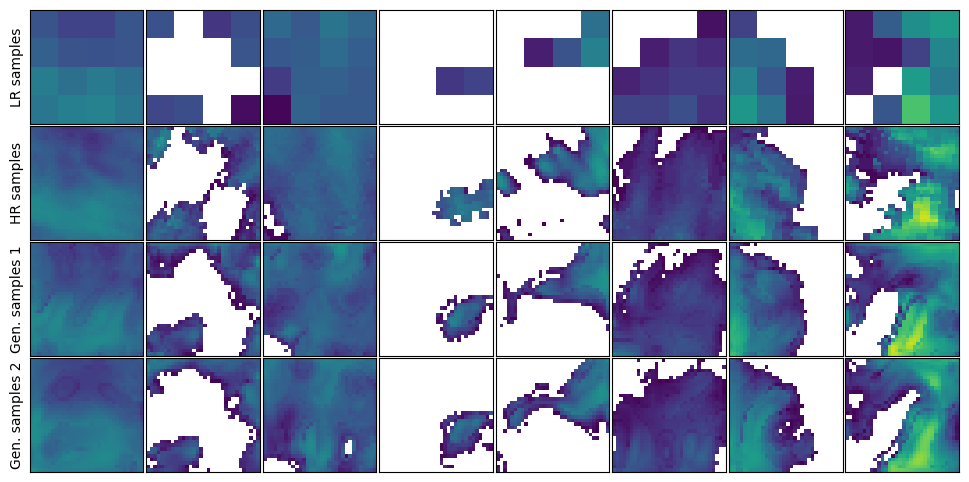

In [14]:
rng = np.random.RandomState(seed=15)
num_samples = 8

# Selection of interesting samples from the test set
indices = [2,5,14,16,17,19,28,37]

# Uncomment to use a random selection (change seed for a different selection):
# indices = rng.choice(samples.shape[0], num_samples, replace=False)

noise = rng.randn(num_samples, 4, 4, 8)
samples_gen_1 = generator.predict_on_batch(
    [samples_lr_test[indices,...], noise]
)
noise = rng.randn(num_samples, 4, 4, 8)
samples_gen_2 = generator.predict_on_batch(
    [samples_lr_test[indices,...], noise]
)
plot_samples(
    [
        samples_lr_test[indices,...], samples_test[indices,...], 
        samples_gen_1, samples_gen_2    
    ],
    labels=["LR samples", "HR samples", "Gen. samples 1", "Gen. samples 2"]
)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
